In [ ]:
print("Instalando dependencias...")
!pip install -q solana requests pandas matplotlib seaborn

In [ ]:
"""
===========================================
BOT MONITOR DE WHALE WALLETS - SOLANA
Clase de Finanzas Cuantitativas
Nivel: Principiante-Intermedio
===========================================

Este script educativo muestra cómo monitorear transacciones
de wallets importantes (ballenas) en Solana usando APIs gratuitas.

OBJETIVO: Entender el flujo de datos on-chain antes del trading.
"""

# ============================================
# 1. INSTALACIÓN DE DEPENDENCIAS
# ============================================

import requests
import pandas as pd
import time
from datetime import datetime, timedelta
from typing import List, Dict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# ============================================
# 2. CONFIGURACIÓN DE APIs
# ============================================

class SolanaWhaleMonitor:
    """Monitor de transacciones de wallets ballena en Solana"""

    def __init__(self):
        self.rpc_url = "https://api.mainnet-beta.solana.com"

        # Wallets famosas para monitorear
        self.whale_wallets = {
            "Binance Hot Wallet": "5tzFkiKscXHK5ZXCGbXZxdw7gTjjD1mBwuoFbhUvuAi9",
            "FTX Cold Wallet": "2nBoNW5B9SdpFC6mb6VXsHbbeRFe2zD3VhCRG8gVi8zg",
        }

        self.sol_to_lamports = 1_000_000_000

    def get_recent_transactions(self, wallet_address: str, limit: int = 10) -> List[Dict]:
        """Obtiene las transacciones recientes de una wallet"""
        payload = {
            "jsonrpc": "2.0",
            "id": 1,
            "method": "getSignaturesForAddress",
            "params": [wallet_address, {"limit": limit}]
        }

        try:
            response = requests.post(self.rpc_url, json=payload, timeout=10)
            data = response.json()

            if 'result' in data:
                return data['result']
            else:
                print(f" Error en respuesta: {data}")
                return []

        except Exception as e:
            print(f" Error al obtener transacciones: {e}")
            return []

    def get_transaction_details(self, signature: str) -> Dict:
        """Obtiene los detalles de una transacción específica"""
        payload = {
            "jsonrpc": "2.0",
            "id": 1,
            "method": "getTransaction",
            "params": [
                signature,
                {"encoding": "json", "maxSupportedTransactionVersion": 0}
            ]
        }

        try:
            response = requests.post(self.rpc_url, json=payload, timeout=10)
            data = response.json()
            return data.get('result', {})
        except Exception as e:
            print(f" Error al obtener detalles: {e}")
            return {}

    def analyze_transaction(self, tx_details: Dict) -> Dict:
        """Analiza una transacción y extrae información relevante"""
        if not tx_details:
            return {}

        meta = tx_details.get('meta', {})
        transaction = tx_details.get('transaction', {})

        pre_balances = meta.get('preBalances', [])
        post_balances = meta.get('postBalances', [])

        balance_change = 0
        if len(pre_balances) > 0 and len(post_balances) > 0:
            balance_change = (post_balances[0] - pre_balances[0]) / self.sol_to_lamports

        return {
            'balance_change_sol': round(balance_change, 4),
            'fee_sol': meta.get('fee', 0) / self.sol_to_lamports,
            'success': meta.get('err') is None,
            'accounts_involved': len(transaction.get('message', {}).get('accountKeys', []))
        }

    def monitor_wallets(self, check_interval: int = 30, iterations: int = 5):
        """Monitorea las wallets configuradas"""
        print("\n" + "="*60)
        print("🐋 INICIANDO MONITOR DE WHALE WALLETS")
        print("="*60)

        results = []

        for iteration in range(iterations):
            print(f"\n Iteración {iteration + 1}/{iterations}")
            print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            print("-" * 60)

            for wallet_name, wallet_address in self.whale_wallets.items():
                print(f"\n🔍 Analizando: {wallet_name}")
                print(f"   Address: {wallet_address[:8]}...{wallet_address[-8:]}")

                transactions = self.get_recent_transactions(wallet_address, limit=5)

                if not transactions:
                    print("   ⚠️ No se encontraron transacciones recientes")
                    continue

                print(f" Encontradas {len(transactions)} transacciones")

                latest_tx = transactions[0]
                signature = latest_tx['signature']

                tx_details = self.get_transaction_details(signature)
                analysis = self.analyze_transaction(tx_details)

                if analysis:
                    result = {
                        'timestamp': datetime.now(),
                        'wallet_name': wallet_name,
                        'wallet_address': wallet_address,
                        'signature': signature,
                        'balance_change': analysis['balance_change_sol'],
                        'fee': analysis['fee_sol'],
                        'success': analysis['success'],
                        'accounts': analysis['accounts_involved']
                    }

                    results.append(result)

                    print(f" Cambio de balance: {analysis['balance_change_sol']:.4f} SOL")
                    print(f" Fee: {analysis['fee_sol']:.6f} SOL")
                    print(f" ✓ Status: {'Exitosa' if analysis['success'] else 'Fallida'}")
                    print(f" Cuentas involucradas: {analysis['accounts_involved']}")

                time.sleep(2)

            if iteration < iterations - 1:
                print(f"\n Esperando {check_interval} segundos...")
                time.sleep(check_interval)

        return pd.DataFrame(results)

In [ ]:
# ============================================
# 3. VISUALIZACIONES ÚTILES PARA TRADING
# ============================================

def create_trading_visualizations(df: pd.DataFrame):
    """
    Crea gráficos ÚTILES para análisis cuantitativo
    """
    if df.empty:
        print(" No hay datos para visualizar")
        return

    print("\n" + "="*60)
    print(" GENERANDO VISUALIZACIONES PARA TRADING")
    print("="*60)

    # Crear figura con múltiples subplots
    fig = plt.figure(figsize=(16, 12))

    # ============================================
    # GRÁFICO 1: Serie de Tiempo de Balance Changes
    # ============================================
    ax1 = plt.subplot(3, 2, 1)

    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet].copy()
        wallet_data = wallet_data.sort_values('timestamp')

        # Línea de tiempo
        ax1.plot(wallet_data['timestamp'],
                wallet_data['balance_change'],
                marker='o',
                linewidth=2,
                markersize=8,
                label=wallet,
                alpha=0.7)

    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.set_xlabel('Tiempo', fontsize=10)
    ax1.set_ylabel('Cambio de Balance (SOL)', fontsize=10)
    ax1.set_title(' EVOLUCIÓN TEMPORAL - Actividad de Wallets', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Agregar anotaciones en movimientos grandes
    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet]
        max_move = wallet_data.loc[wallet_data['balance_change'].abs().idxmax()]
        if abs(max_move['balance_change']) > 100:  # Solo si es significativo
            ax1.annotate(f"{max_move['balance_change']:.0f} SOL",
                        xy=(max_move['timestamp'], max_move['balance_change']),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                        fontsize=8)

    # ============================================
    # GRÁFICO 2: Distribución de Movimientos (Histograma)
    # ============================================
    ax2 = plt.subplot(3, 2, 2)

    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet]
        ax2.hist(wallet_data['balance_change'],
                bins=15,
                alpha=0.6,
                label=wallet,
                edgecolor='black')

    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Cambio de Balance (SOL)', fontsize=10)
    ax2.set_ylabel('Frecuencia', fontsize=10)
    ax2.set_title(' DISTRIBUCIÓN - ¿Compran o Venden Más?', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

    # ============================================
    # GRÁFICO 3: Balance Acumulado (Cumulative Sum)
    # ============================================
    ax3 = plt.subplot(3, 2, 3)

    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet].copy()
        wallet_data = wallet_data.sort_values('timestamp')
        wallet_data['cumulative_balance'] = wallet_data['balance_change'].cumsum()

        ax3.plot(wallet_data['timestamp'],
                wallet_data['cumulative_balance'],
                marker='s',
                linewidth=2.5,
                markersize=6,
                label=wallet)

        # Agregar área bajo la curva
        ax3.fill_between(wallet_data['timestamp'],
                         wallet_data['cumulative_balance'],
                         alpha=0.2)

    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Tiempo', fontsize=10)
    ax3.set_ylabel('Balance Acumulado (SOL)', fontsize=10)
    ax3.set_title('💰 FLUJO NETO ACUMULADO - ¿Están Acumulando o Distribuyendo?',
                 fontsize=12, fontweight='bold')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

    # ============================================
    # GRÁFICO 4: Comparación de Volumen por Wallet (Barras)
    # ============================================
    ax4 = plt.subplot(3, 2, 4)

    volume_data = df.groupby('wallet_name').agg({
        'balance_change': lambda x: x.abs().sum(),  # Volumen total
        'accounts': 'mean'  # Promedio de cuentas involucradas
    }).reset_index()

    colors = plt.cm.Set3(np.linspace(0, 1, len(volume_data)))
    bars = ax4.bar(volume_data['wallet_name'],
                   volume_data['balance_change'],
                   color=colors,
                   edgecolor='black',
                   linewidth=1.5)

    # Agregar valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f} SOL',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax4.set_ylabel('Volumen Total (SOL)', fontsize=10)
    ax4.set_title(' VOLUMEN TOTAL - ¿Quién Mueve Más Dinero?', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')

    # ============================================
    # GRÁFICO 5: Heatmap de Actividad por Hora
    # ============================================
    ax5 = plt.subplot(3, 2, 5)

    df_heatmap = df.copy()
    df_heatmap['hour'] = df_heatmap['timestamp'].dt.hour
    df_heatmap['minute'] = df_heatmap['timestamp'].dt.minute

    # Crear matriz de actividad
    pivot_data = df_heatmap.groupby(['wallet_name', 'hour'])['balance_change'].sum().unstack(fill_value=0)

    if not pivot_data.empty:
        sns.heatmap(pivot_data,
                   annot=True,
                   fmt='.0f',
                   cmap='RdYlGn',
                   center=0,
                   ax=ax5,
                   cbar_kws={'label': 'Balance Change (SOL)'})

    ax5.set_title(' HEATMAP - ¿A Qué Hora Operan?', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Hora del Día', fontsize=10)
    ax5.set_ylabel('Wallet', fontsize=10)

    # ============================================
    # GRÁFICO 6: Ratio Compra/Venta (Pie Chart)
    # ============================================
    ax6 = plt.subplot(3, 2, 6)

    buys = len(df[df['balance_change'] > 0])
    sells = len(df[df['balance_change'] < 0])
    neutral = len(df[df['balance_change'] == 0])

    sizes = [buys, sells, neutral]
    labels = [f'Compras ({buys})', f'Ventas ({sells})', f'Neutral ({neutral})']
    colors_pie = ['#2ecc71', '#e74c3c', '#95a5a6']
    explode = (0.1, 0.1, 0)

    ax6.pie(sizes,
           explode=explode,
           labels=labels,
           colors=colors_pie,
           autopct='%1.1f%%',
           shadow=True,
           startangle=90,
           textprops={'fontsize': 10, 'fontweight': 'bold'})

    ax6.set_title(' SENTIMIENTO - ¿Alcista o Bajista?', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('whale_analysis_dashboard.png', dpi=150, bbox_inches='tight')
    print("\n💾 Dashboard guardado como: whale_analysis_dashboard.png")
    plt.show()

In [ ]:
# ============================================
# 4. MÉTRICAS CUANTITATIVAS
# ============================================

def calculate_trading_metrics(df: pd.DataFrame):
    """
    Calcula métricas cuantitativas útiles para trading
    """
    if df.empty:
        return

    print("\n" + "="*60)
    print(" MÉTRICAS CUANTITATIVAS PARA TRADING")
    print("="*60)

    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet].copy()

        print(f"\n {wallet}")
        print("-" * 50)

        # 1. Volumen total
        total_volume = wallet_data['balance_change'].abs().sum()
        print(f" Volumen Total: {total_volume:,.2f} SOL")

        # 2. Flujo neto
        net_flow = wallet_data['balance_change'].sum()
        print(f" Flujo Neto: {net_flow:,.2f} SOL")

        # 3. Ratio compra/venta
        buys = wallet_data[wallet_data['balance_change'] > 0]['balance_change'].sum()
        sells = abs(wallet_data[wallet_data['balance_change'] < 0]['balance_change'].sum())
        ratio = buys / sells if sells > 0 else 0
        print(f"  Ratio Compra/Venta: {ratio:.2f}")

        # 4. Movimiento promedio
        avg_move = wallet_data['balance_change'].mean()
        print(f" Movimiento Promedio: {avg_move:,.2f} SOL")

        # 5. Volatilidad (Desviación estándar)
        volatility = wallet_data['balance_change'].std()
        print(f" Volatilidad: {volatility:,.2f} SOL")

        # 6. Movimiento máximo
        max_buy = wallet_data['balance_change'].max()
        max_sell = wallet_data['balance_change'].min()
        print(f"🔺 Compra Máxima: {max_buy:,.2f} SOL")
        print(f"🔻 Venta Máxima: {max_sell:,.2f} SOL")

        # 7. Frecuencia de trading
        time_span = (wallet_data['timestamp'].max() - wallet_data['timestamp'].min()).total_seconds() / 60
        frequency = len(wallet_data) / time_span if time_span > 0 else 0
        print(f" Frecuencia: {frequency:.2f} transacciones/minuto")

        # 8. Tasa de éxito
        success_rate = wallet_data['success'].sum() / len(wallet_data) * 100
        print(f" Tasa de Éxito: {success_rate:.1f}%")



In [ ]:
# ============================================
# 5. ALERTAS DE TRADING
# ============================================

def generate_trading_alerts(df: pd.DataFrame):
    """
    Genera alertas basadas en los datos
    """
    if df.empty:
        return

    print("\n" + "="*60)
    print(" ALERTAS DE TRADING")
    print("="*60)

    # Definir umbrales (ajustables según tu estrategia)
    THRESHOLD_LARGE_MOVE = 1000  # SOL
    THRESHOLD_UNUSUAL_VOLUME = 5000  # SOL

    alerts = []

    for wallet in df['wallet_name'].unique():
        wallet_data = df[df['wallet_name'] == wallet]

        # Alerta 1: Movimiento grande reciente
        latest = wallet_data.iloc[-1]
        if abs(latest['balance_change']) > THRESHOLD_LARGE_MOVE:
            action = "COMPRA" if latest['balance_change'] > 0 else "VENTA"
            alerts.append({
                'type': 'MOVIMIENTO GRANDE',
                'wallet': wallet,
                'action': action,
                'amount': abs(latest['balance_change']),
                'urgency': '🔴 ALTA'
            })

        # Alerta 2: Volumen inusual
        total_volume = wallet_data['balance_change'].abs().sum()
        if total_volume > THRESHOLD_UNUSUAL_VOLUME:
            alerts.append({
                'type': 'VOLUMEN INUSUAL',
                'wallet': wallet,
                'action': 'MÚLTIPLES TRANSACCIONES',
                'amount': total_volume,
                'urgency': '🟡 MEDIA'
            })

        # Alerta 3: Tendencia sostenida
        net_flow = wallet_data['balance_change'].sum()
        if net_flow < -2000:
            alerts.append({
                'type': 'DISTRIBUCIÓN SOSTENIDA',
                'wallet': wallet,
                'action': 'VENTA CONTINUA',
                'amount': abs(net_flow),
                'urgency': '🔴 ALTA'
            })
        elif net_flow > 2000:
            alerts.append({
                'type': 'ACUMULACIÓN SOSTENIDA',
                'wallet': wallet,
                'action': 'COMPRA CONTINUA',
                'amount': net_flow,
                'urgency': '🟢 POSITIVA'
            })

    # Mostrar alertas
    if alerts:
        for alert in alerts:
            print(f"\n{alert['urgency']} {alert['type']}")
            print(f"   Wallet: {alert['wallet']}")
            print(f"   Acción: {alert['action']}")
            print(f"   Monto: {alert['amount']:,.2f} SOL")
    else:
        print("\n No hay alertas significativas en este período")


    ╔══════════════════════════════════════════════════════════╗
    ║   BOT MONITOR DE WHALE WALLETS                           ║
    ║                                                          ║
    ╚══════════════════════════════════════════════════════════╝
    

🚀 Iniciando monitoreo...

🐋 INICIANDO MONITOR DE WHALE WALLETS

📊 Iteración 1/5
⏰ 2025-10-31 14:08:17
------------------------------------------------------------

🔍 Analizando: Binance Hot Wallet
   Address: 5tzFkiKs...bhUvuAi9
   ✅ Encontradas 5 transacciones
   💰 Cambio de balance: -0.4734 SOL
   💸 Fee: 0.000011 SOL
   ✓ Status: Exitosa
   👥 Cuentas involucradas: 7

🔍 Analizando: FTX Cold Wallet
   Address: 2nBoNW5B...G8gVi8zg
   ⚠️ No se encontraron transacciones recientes

⏳ Esperando 30 segundos...

📊 Iteración 2/5
⏰ 2025-10-31 14:08:49
------------------------------------------------------------

🔍 Analizando: Binance Hot Wallet
   Address: 5tzFkiKs...bhUvuAi9
   ✅ Encontradas 5 transacciones
   💰 Cambio de balance: 

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/tmp/ipython-input-3423527113.py:187: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3423527113.py:187: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3423527113.py:188: UserWarning: G


💾 Dashboard guardado como: whale_analysis_dashboard.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128336 (\N{CLOCK FACE ONE OCLOCK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

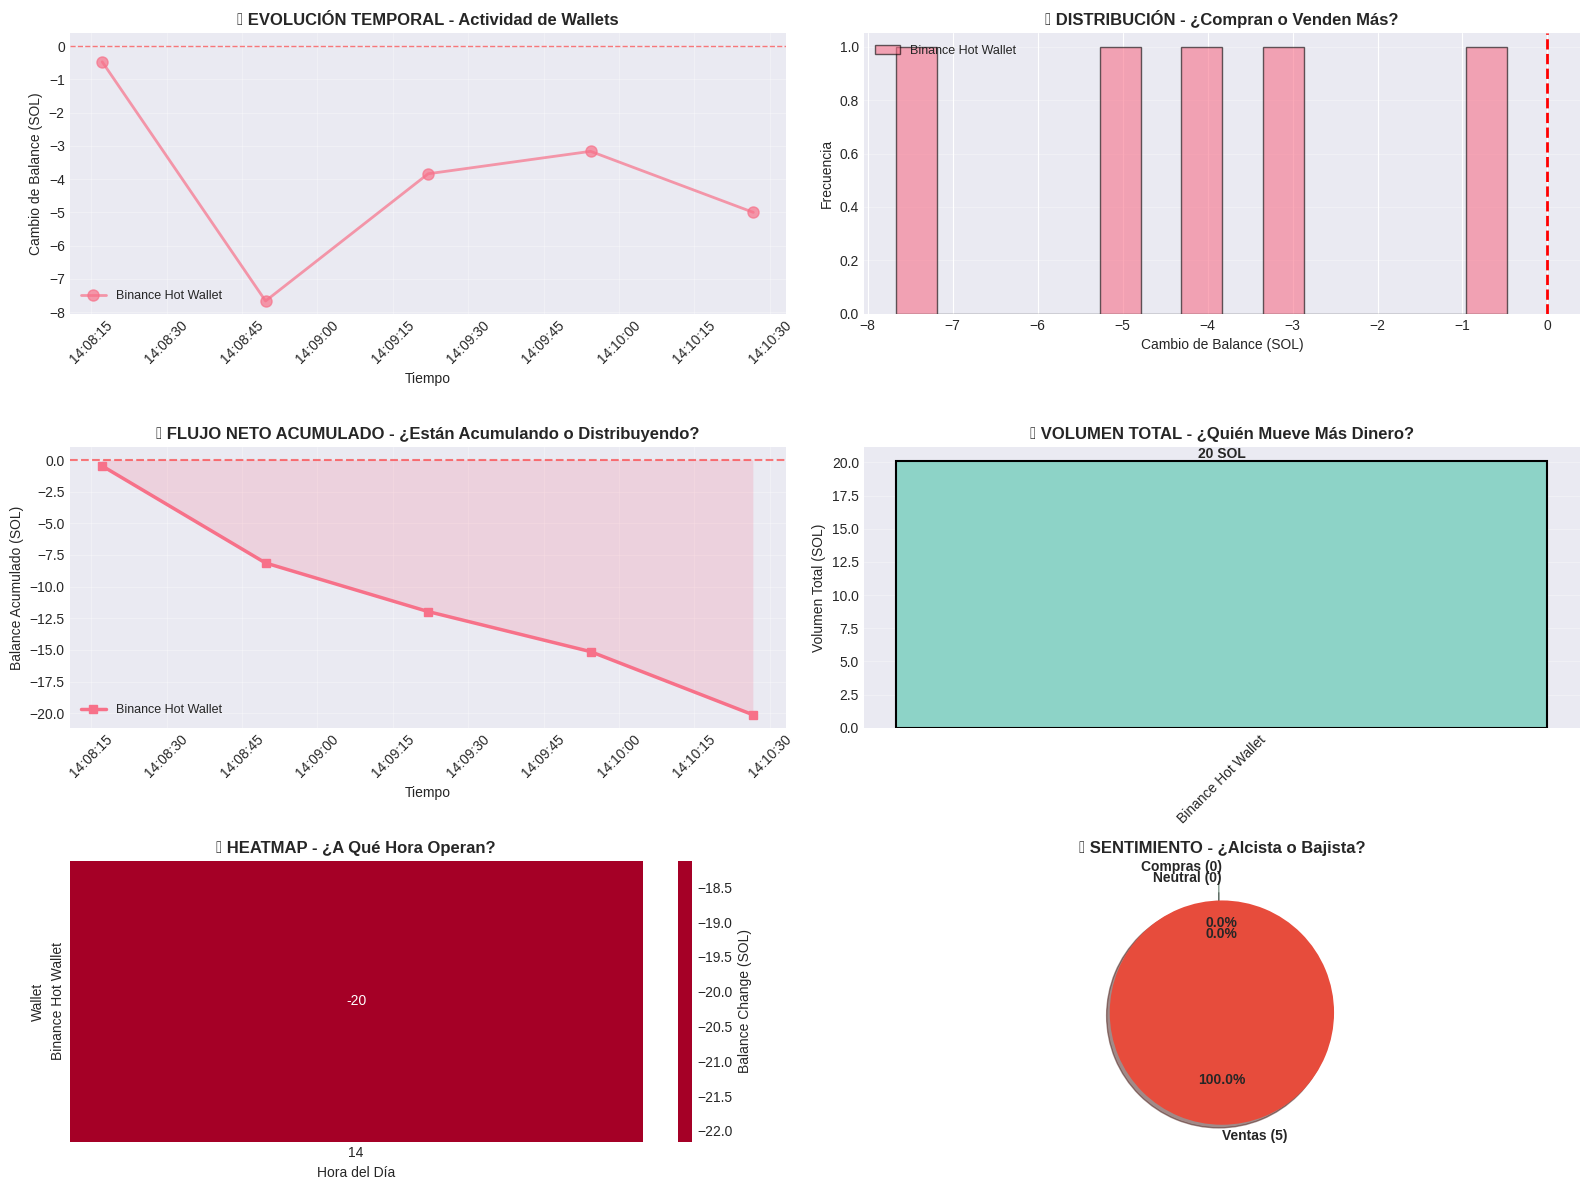


📐 MÉTRICAS CUANTITATIVAS PARA TRADING

🔷 Binance Hot Wallet
--------------------------------------------------
📊 Volumen Total: 20.14 SOL
💵 Flujo Neto: -20.14 SOL
⚖️  Ratio Compra/Venta: 0.00
📈 Movimiento Promedio: -4.03 SOL
📉 Volatilidad: 2.63 SOL
🔺 Compra Máxima: -0.47 SOL
🔻 Venta Máxima: -7.66 SOL
⚡ Frecuencia: 2.32 transacciones/minuto
✅ Tasa de Éxito: 100.0%

🚨 ALERTAS DE TRADING

✅ No hay alertas significativas en este período

💾 Datos exportados: whale_data_20251031_141031.csv

✅ Análisis completado!


In [ ]:
# ============================================
# 6. EJECUCIÓN PRINCIPAL
# ============================================

if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════════════╗
    ║   BOT MONITOR DE WHALE WALLETS                           ║
    ║                                                          ║
    ╚══════════════════════════════════════════════════════════╝
    """)

    # Crear instancia del monitor
    monitor = SolanaWhaleMonitor()

    # Ejecutar monitoreo
    print("\n Iniciando monitoreo...")
    df_results = monitor.monitor_wallets(
        check_interval=30,
        iterations=5
    )

    # Análisis y visualizaciones
    if not df_results.empty:
        # Generar dashboard visual
        create_trading_visualizations(df_results)

        # Calcular métricas
        calculate_trading_metrics(df_results)

        # Generar alertas
        generate_trading_alerts(df_results)

        # Exportar datos
        filename = f"whale_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_results.to_csv(filename, index=False)
        print(f"\n Datos exportados: {filename}")

    print("\n Análisis completado!")